In [1]:
import os
import sys
import numpy as np
import shapefile as sf
import shapely
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import pandas as pd
import shutil
import time
import vtk;

C:\Users\nikol\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\nikol\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\nikol\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\nikol\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\nikol\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 19

In [2]:
import ipyvtk_simple
import pyvista as pv
import PVGeo
from PVGeo.gslib import GSLibReader
from PVGeo.grids import TableToTimeGrid;
import gdal
from mpl_toolkits.mplot3d import Axes3D # <--- This is important for 3d plotting 

C:\Users\nikol\Anaconda3\lib\site-packages\osgeo\gdal.py:107: DeprecationWarning: gdal.py was placed in a namespace, it is now available as osgeo.gdal
  DeprecationWarning)


In [3]:
def gslib_to_ndarray(nrow,ncol,nlay,nreal,threshold,nlay_out,thick_lay):
    #The function provides a resistivity array and an array with values of 1 and 2
    #for clays and sand respectively, depending on the threshold. The arrays are based on the nth realization
    #The output arrays are flattened so the model top can be set in MODFLOW.
    #It requires following packages: Numpy, PVGeo, OS
    #nrow: Number of rows in the realization
    #ncol: Number of columns in the realization
    #nlay: Number of layers in the realization
    #nreal: The number of the realization 00 being the first realization.
    #Threshold: The resistivity threshold seperating clay and sand
    
    filename = os.path.join(r'C:\Users\nikol\Dropbox\Universitet\MasterThesis\Fenshoj_05m_first50\Fenshoj_005_dec8v3_real000{}.gslib'.format(nreal))
    
    #First read gslib file
    reader = PVGeo.gslib.GSLibReader()
    realization = reader.apply(filename)
    
    #Then make the gslib file to ndarray with nan values at -9.99999e+6 values
    real_arr = []
    for i in range(len(realization[0])):
        if realization[0][i] > -8.999999e+06: 
            real_arr.append(realization[0][i])
        elif realization[0][i] < -8.999999e+06:
            real_arr.append(np.nan) 
            
    #Then make ndarray size (nlay, nrow, ncol) for rho model
    n = 0
    res_arr = []
    col_arr = []
    row_arr = []
    for k in range(nlay):
        for i in range(nrow):
            for j in range(ncol):
                col_arr.append(10 ** real_arr[n])
                n = n+1
                if len(col_arr)==ncol:
                    row_arr.append(col_arr)
                    col_arr = []
                if len(row_arr)==nrow:
                    res_arr.append(row_arr[::-1])
                    row_arr = []
                    
    res_arr = np.asarray(res_arr[::-1])
    
    #Flatten all layers in the realization
    res_list = []
    len_arr = []

    for i in range(np.shape(res_arr)[1]):
        for j in range(np.shape(res_arr)[2]):
            vert_arr = [v for v in res_arr[:,i,j] if ~np.isnan(v)]
            res_list.append(vert_arr)
            len_arr.append(len(vert_arr))
        
    min_depth = min(len_arr)

    for i in range(len(res_list)):
        res_list[i] = res_list[i][0:min_depth]
    
    res_final = np.zeros((min_depth,nrow,ncol))

    n=0

    for i in range(nrow):
        for j in range(ncol):
            for k in range(min_depth):
                res_final[k,i,j] = res_list[n][k]
            n=n+1
            
    init_arr = np.copy(res_final)
    
    n_last_layer = thick_lay*2 #2 cause 1 layer is 0.5 m
    
    init_arr[nlay_out-1,:,:] = np.mean(init_arr[(nlay_out-1):(nlay_out+n_last_layer),:,:])
    
    threshold_arr = []
    
    for i in range(nlay_out):
        threshold_arr.append(init_arr[i,:,:])
    
    threshold_arr = np.asarray(threshold_arr)
    
    res_used = np.copy(threshold_arr)
        
    #Seperate clay and sand set by threshold
    threshold_arr[res_used>threshold] = 2
    threshold_arr[res_used<threshold] = 1
    
    return res_final, res_used, threshold_arr

In [4]:
threshold = 80
nrow = 120
ncol = 140
nlay = 160
nreal = '10'
nlay_out = 12
thick_lay = 10

res_final, res_arr, threshold_arr = gslib_to_ndarray(nrow,ncol,nlay,nreal,threshold,nlay_out,thick_lay)

In [5]:
np.shape(res_arr), np.shape(threshold_arr)

((12, 120, 140), (12, 120, 140))

<>:15: DeprecationWarning: invalid escape sequence \O
<>:15: DeprecationWarning: invalid escape sequence \O
<>:15: DeprecationWarning: invalid escape sequence \O
<ipython-input-6-0cda43ce33ab>:15: DeprecationWarning: invalid escape sequence \O
  cb1.set_label('$\Omega$m', fontsize=12)


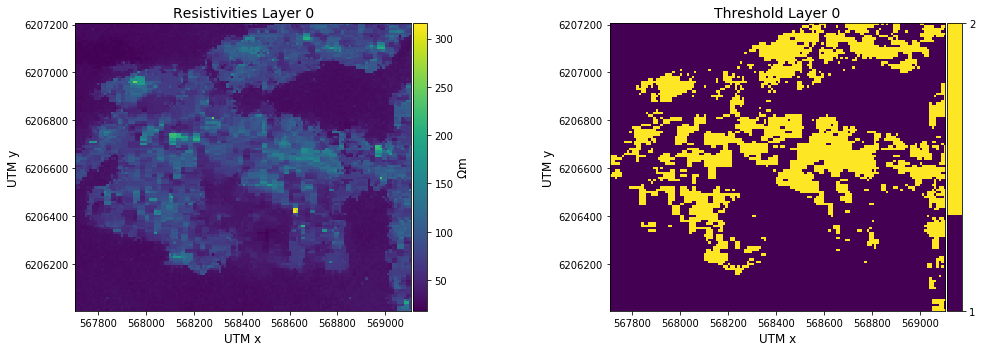

In [6]:
top = mpl.cm.get_cmap('viridis', 256)
bottom = mpl.cm.get_cmap('viridis', 256)

newcolors = np.vstack((top(np.linspace(0, 1, 1)),
                       bottom(np.linspace(1, 1, 2))))
newcmp = mpl.colors.ListedColormap(newcolors, name='Virids')

fig, axs = plt.subplots(1,2, figsize=(15,5))

im1 = axs[0].imshow(res_arr[0], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)))
axs[0].set_title('Resistivities Layer 0', fontsize=14)
axs[0].set_xlabel('UTM x', fontsize=12)
axs[0].set_ylabel('UTM y', fontsize=12)
cb1 = fig.colorbar(im1, ax=axs[0], pad=0.005)
cb1.set_label('$\Omega$m', fontsize=12)

im2 = axs[1].imshow(threshold_arr[0], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)), cmap=newcmp)
axs[1].set_title('Threshold Layer 0', fontsize=14)
axs[1].set_xlabel('UTM x', fontsize=12)
axs[1].set_ylabel('UTM y', fontsize=12)
cb2 = fig.colorbar(im2, ax=axs[1], pad=0.005, ticks=(1, 2),  spacing=['uniform'])

plt.tight_layout()
plt.show;
fig.savefig(os.path.join(r'C:\Users\nikol\Dropbox\Universitet\MasterThesis\Latex\Pictures\res_th_plot_l0'))

<>:8: DeprecationWarning: invalid escape sequence \O
<>:15: DeprecationWarning: invalid escape sequence \O
<>:22: DeprecationWarning: invalid escape sequence \O
<>:29: DeprecationWarning: invalid escape sequence \O
<>:8: DeprecationWarning: invalid escape sequence \O
<>:15: DeprecationWarning: invalid escape sequence \O
<>:22: DeprecationWarning: invalid escape sequence \O
<>:29: DeprecationWarning: invalid escape sequence \O
<>:8: DeprecationWarning: invalid escape sequence \O
<>:15: DeprecationWarning: invalid escape sequence \O
<>:22: DeprecationWarning: invalid escape sequence \O
<>:29: DeprecationWarning: invalid escape sequence \O
<ipython-input-7-919c4384223b>:8: DeprecationWarning: invalid escape sequence \O
  cb1.set_label('$\Omega$m', fontsize=12)
<ipython-input-7-919c4384223b>:15: DeprecationWarning: invalid escape sequence \O
  cb2.set_label('$\Omega$m', fontsize=12)
<ipython-input-7-919c4384223b>:22: DeprecationWarning: invalid escape sequence \O
  cb1.set_label('$\Omega$m

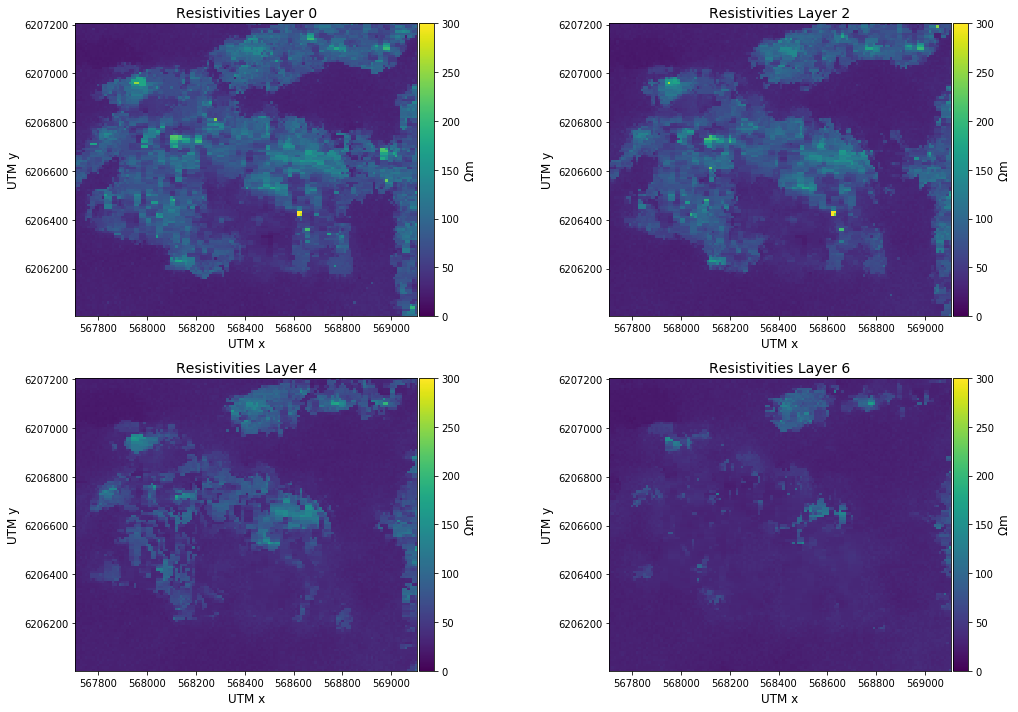

In [7]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

im1 = axs[0, 0].imshow(res_arr[0], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)), vmin=0, vmax=300)
axs[0, 0].set_title('Resistivities Layer 0', fontsize=14)
axs[0, 0].set_xlabel('UTM x', fontsize=12)
axs[0, 0].set_ylabel('UTM y', fontsize=12)
cb1 = fig.colorbar(im1, ax=axs[0, 0], pad=0.005)
cb1.set_label('$\Omega$m', fontsize=12)

im2 = axs[0, 1].imshow(res_arr[2], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)), vmin=0, vmax=300)
axs[0, 1].set_title('Resistivities Layer 2', fontsize=14)
axs[0, 1].set_xlabel('UTM x', fontsize=12)
axs[0, 1].set_ylabel('UTM y', fontsize=12)
cb2 = fig.colorbar(im1, ax=axs[0, 1], pad=0.005, )
cb2.set_label('$\Omega$m', fontsize=12)

im1 = axs[1, 0].imshow(res_arr[4], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)), vmin=0, vmax=300)
axs[1, 0].set_title('Resistivities Layer 4', fontsize=14)
axs[1, 0].set_xlabel('UTM x', fontsize=12)
axs[1, 0].set_ylabel('UTM y', fontsize=12)
cb1 = fig.colorbar(im1, ax=axs[1, 0], pad=0.005)
cb1.set_label('$\Omega$m', fontsize=12)

im1 = axs[1, 1].imshow(res_arr[6], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)), vmin=0, vmax=300)
axs[1, 1].set_title('Resistivities Layer 6', fontsize=14)
axs[1, 1].set_xlabel('UTM x', fontsize=12)
axs[1, 1].set_ylabel('UTM y', fontsize=12)
cb1 = fig.colorbar(im1, ax=axs[1, 1], pad=0.005)
cb1.set_label('$\Omega$m', fontsize=12)

plt.tight_layout()
plt.show;
fig.savefig(os.path.join(r'C:\Users\nikol\Dropbox\Universitet\MasterThesis\Latex\Pictures\res_th_plot_l_all'))

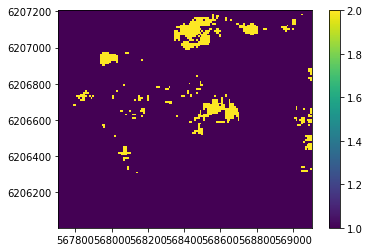

In [8]:
plt.imshow(threshold_arr[5], extent=(567706.0, 567706.0+(140*10), 6206005, 6206005+(120*10)))

plt.colorbar()

In [9]:
file1 = open('res_array_real{}'.format(nreal), 'wb')
np.save(file1, res_final)
file1.close

<function BufferedWriter.close>

In [10]:
file2 = open('threshold_array_th={}'.format(threshold), 'wb')
np.save(file2, threshold_arr)
file2.close

<function BufferedWriter.close>